# Semi-supervised learning for predicting survival time in multiple meyloma patients

## Data Analysis and Preprocessing

### Imports

In [270]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import missingno as msno
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.experimental import enable_iterative_imputer
from sklearn.model_selection import KFold, train_test_split
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression


### Load data and explore

In [3]:
train_df = pd.read_csv("./data/train_data.csv", index_col=0)
test_df = pd.read_csv("./data/test_data.csv").drop(columns=["id"])

In [3]:
train_df.head()

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
0,76.0,1,4,NaN,0,1.0,0.0,2.9,0
1,63.0,1,3,0.0,0,1.0,0.0,4.7,0
2,64.0,0,2,0.0,0,0.0,0.0,NaN,0
3,56.0,0,3,1.0,0,1.0,0.0,2.9,0
4,67.0,1,3,1.0,0,3.0,1.0,3.0,0


In [4]:
train_df.describe()

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse,SurvivalTime,Censored
count,400.000000,400.000000,400.000000,320.000000,400.000000,330.000000,379.000000,310.000000,400.0000
mean,64.290000,0.567500,2.545000,0.275000,0.405000,0.984848,0.503958,3.843871,0.2475
std,9.907639,0.496043,1.075111,0.447214,0.491507,0.862815,0.500645,1.378597,0.4321
min,40.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.800000,0.0000
25%,57.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,2.825000,0.0000
50%,64.000000,1.000000,2.000000,0.000000,0.000000,1.000000,1.000000,3.700000,0.0000
75%,71.000000,1.000000,4.000000,1.000000,1.000000,2.000000,1.000000,4.700000,0.0000
max,90.000000,1.000000,4.000000,1.000000,1.000000,3.000000,1.000000,8.300000,1.0000


In [5]:
test_df.head()

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse
0,60.0,1,2,1.0,0,0.0,1.0
1,49.0,0,1,1.0,0,NaN,0.0
2,57.0,1,1,0.0,1,0.0,1.0
3,61.0,1,3,0.0,1,1.0,0.0
4,64.0,1,2,0.0,0,1.0,1.0


In [6]:
test_df.describe()

,Age,Gender,Stage,GeneticRisk,TreatmentType,ComorbidityIndex,TreatmentResponse
count,100.000000,100.000000,100.00000,86.000000,100.000000,86.000000,98.000000
mean,63.840000,0.650000,2.66000,0.255814,0.400000,1.081395,0.500000
std,9.372989,0.479372,1.08451,0.438877,0.492366,0.935762,0.502571
min,40.000000,0.000000,1.00000,0.000000,0.000000,0.000000,0.000000
25%,58.000000,0.000000,2.00000,0.000000,0.000000,0.000000,0.000000
50%,63.500000,1.000000,3.00000,0.000000,0.000000,1.000000,0.500000
75%,69.250000,1.000000,4.00000,0.750000,1.000000,2.000000,1.000000
max,87.000000,1.000000,4.00000,1.000000,1.000000,3.000000,1.000000


### Check distributions

In [7]:
def plot_distribution(dataframe):
    num_cols = dataframe.shape[1]
    num_rows = (num_cols // 3) + (num_cols % 3)
    num_cols_in_subplot = 3
    
    fig, axes = plt.subplots(num_rows, num_cols_in_subplot, figsize=(15, num_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(dataframe.columns):
        ax = axes[i]
        ax.hist(dataframe[col], bins="auto", color="teal", edgecolor="black")
        ax.set_title(col)
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()

Train data:


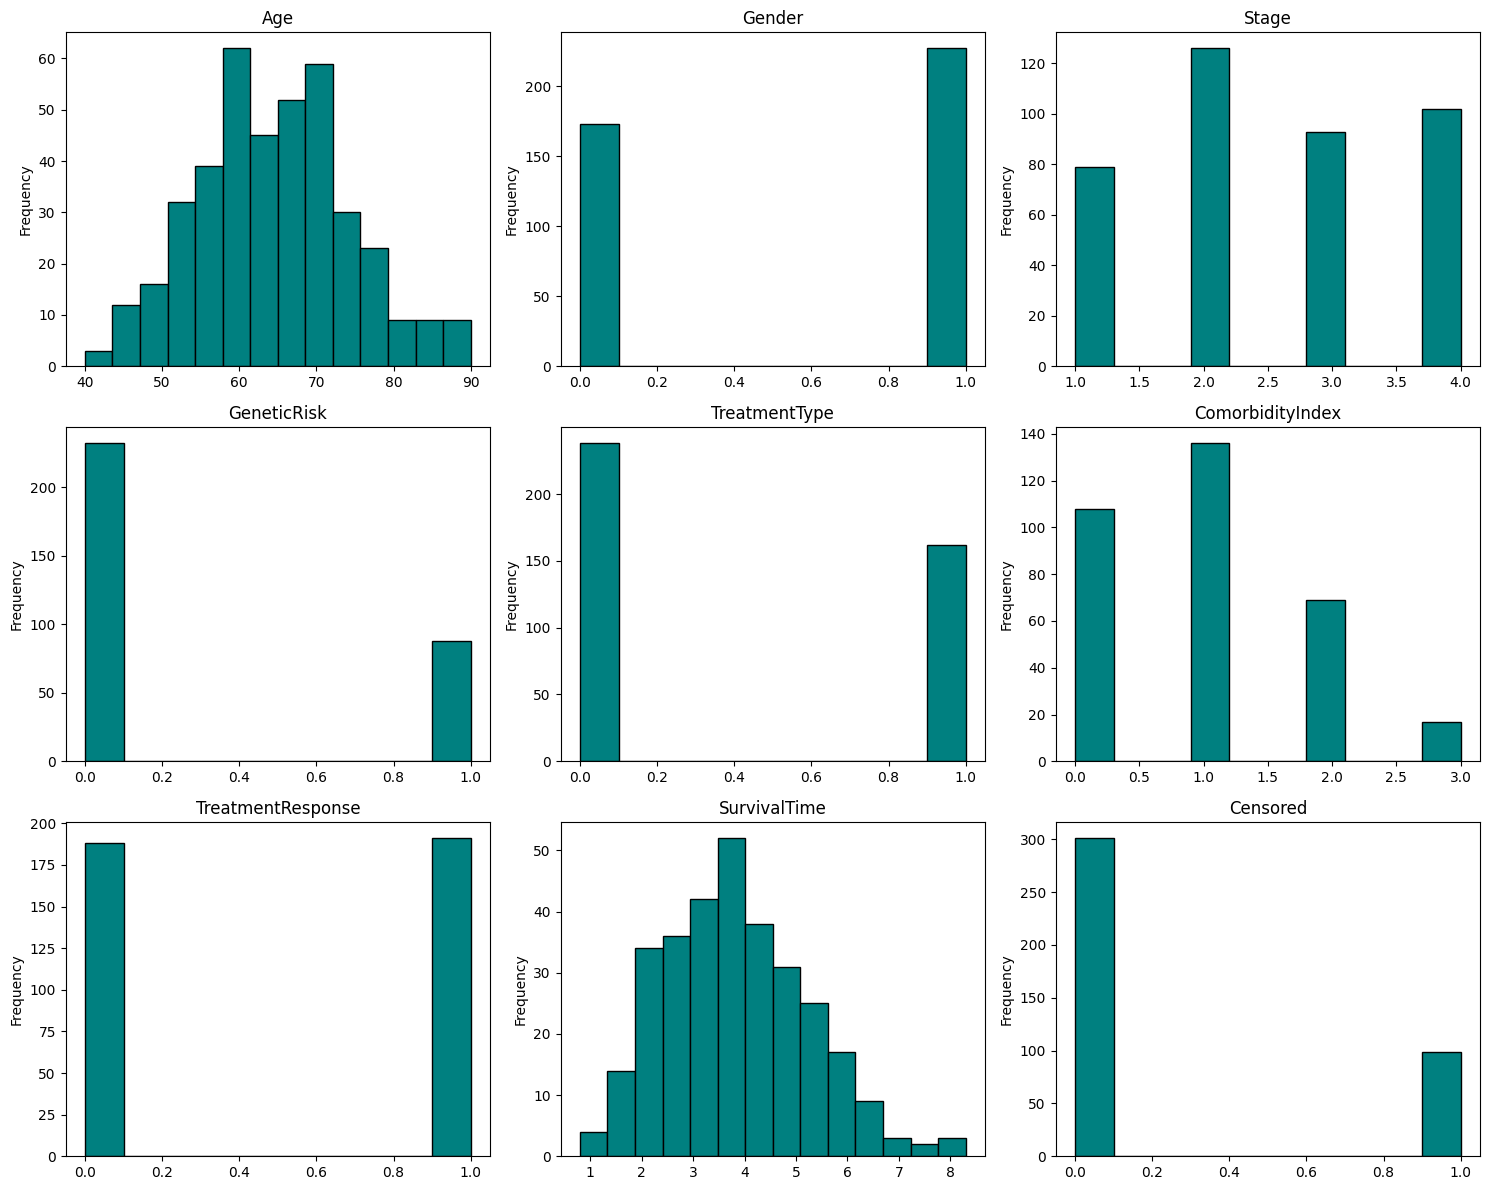

In [8]:
print("Train data:")
plot_distribution(train_df)

Test data:


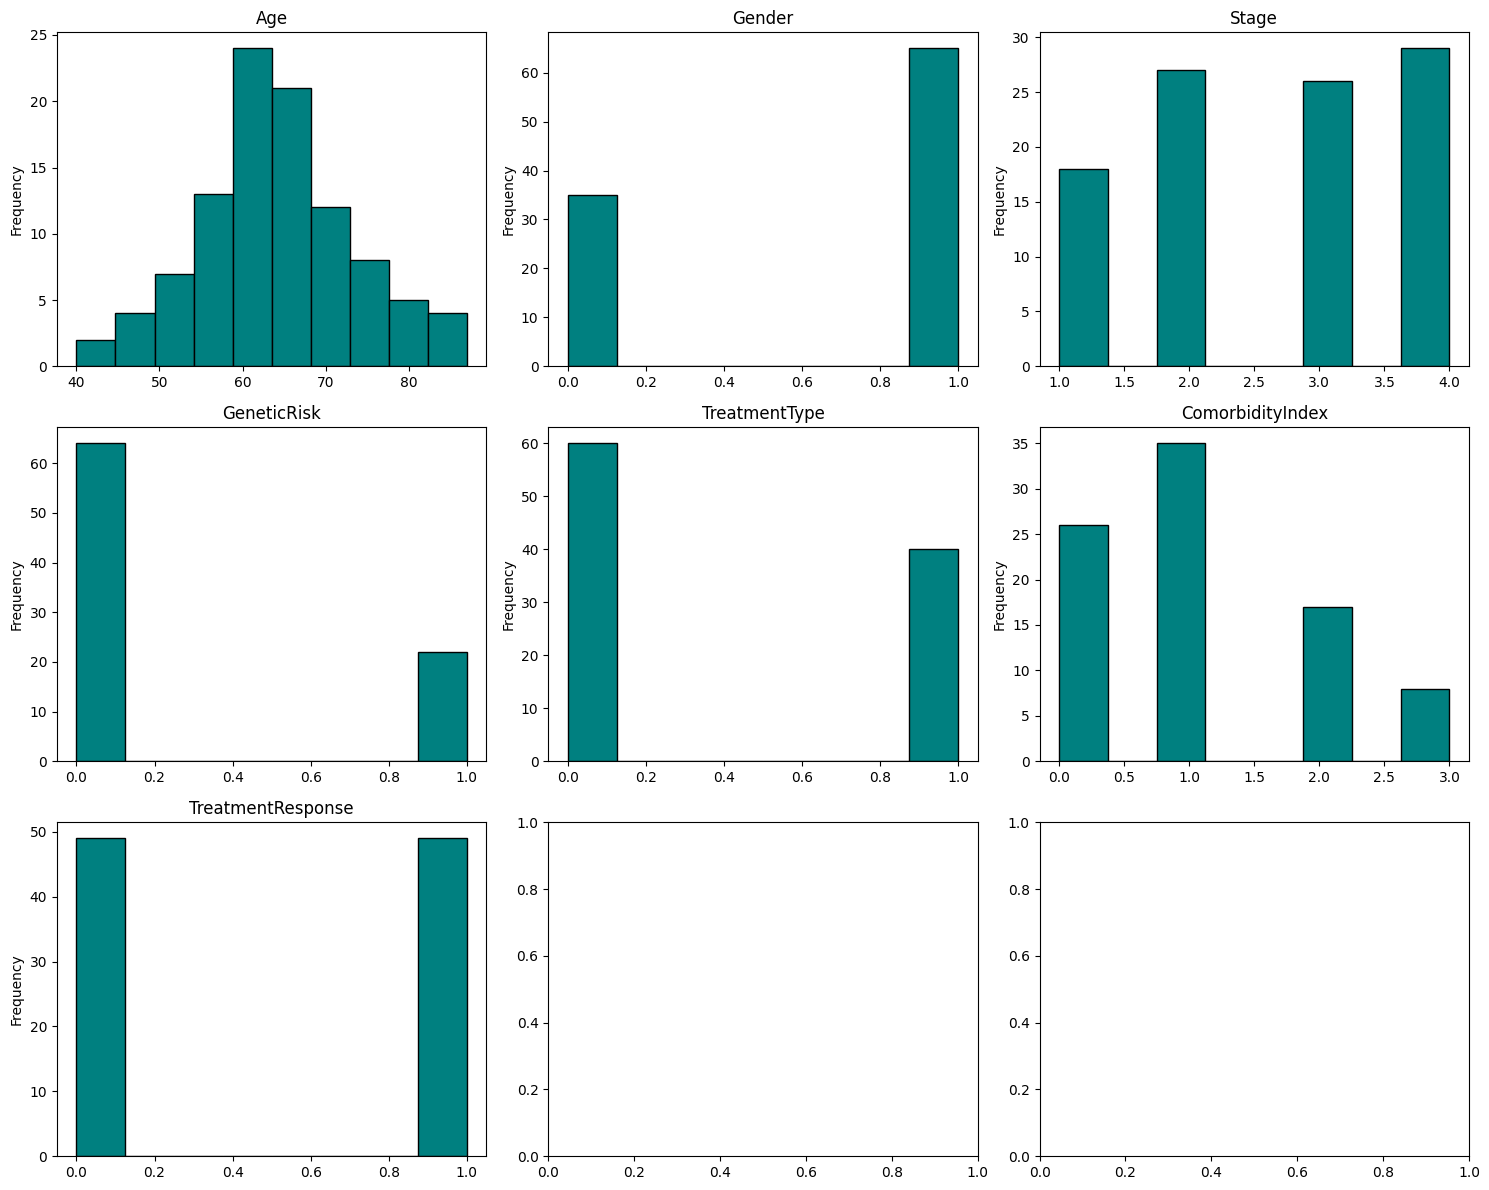

In [9]:
print("Test data:")
plot_distribution(test_df)

### Check NaN vaules

In [10]:
print(f"Number of records in train dataset: {len(train_df)}")
print(f"Number of rows with at least one NaN in train dataset: {train_df.isnull().any(axis=1).sum()}")
print(f"Number of rows containing Nan by column in train dataset:\n{(train_df.isnull().mean() * 100).round(2)}")

print(f"\nNumber of records in test dataset: {len(test_df)}")
print(f"Number of rows with at least one NaN in test dataset: {test_df.isnull().any(axis=1).sum()}")
print(f"Number of rows containing Nan by column in test dataset:\n{(test_df.isnull().mean() * 100).round(2)}")

Number of records in train dataset: 400
Number of rows with at least one NaN in train dataset: 215
Number of rows containing Nan by column in train dataset:
Age                   0.00
Gender                0.00
Stage                 0.00
GeneticRisk          20.00
TreatmentType         0.00
ComorbidityIndex     17.50
TreatmentResponse     5.25
SurvivalTime         22.50
Censored              0.00
dtype: float64

Number of records in test dataset: 100
Number of rows with at least one NaN in test dataset: 30
Number of rows containing Nan by column in test dataset:
Age                   0.0
Gender                0.0
Stage                 0.0
GeneticRisk          14.0
TreatmentType         0.0
ComorbidityIndex     14.0
TreatmentResponse     2.0
dtype: float64


### Missing data patterns

Train data:


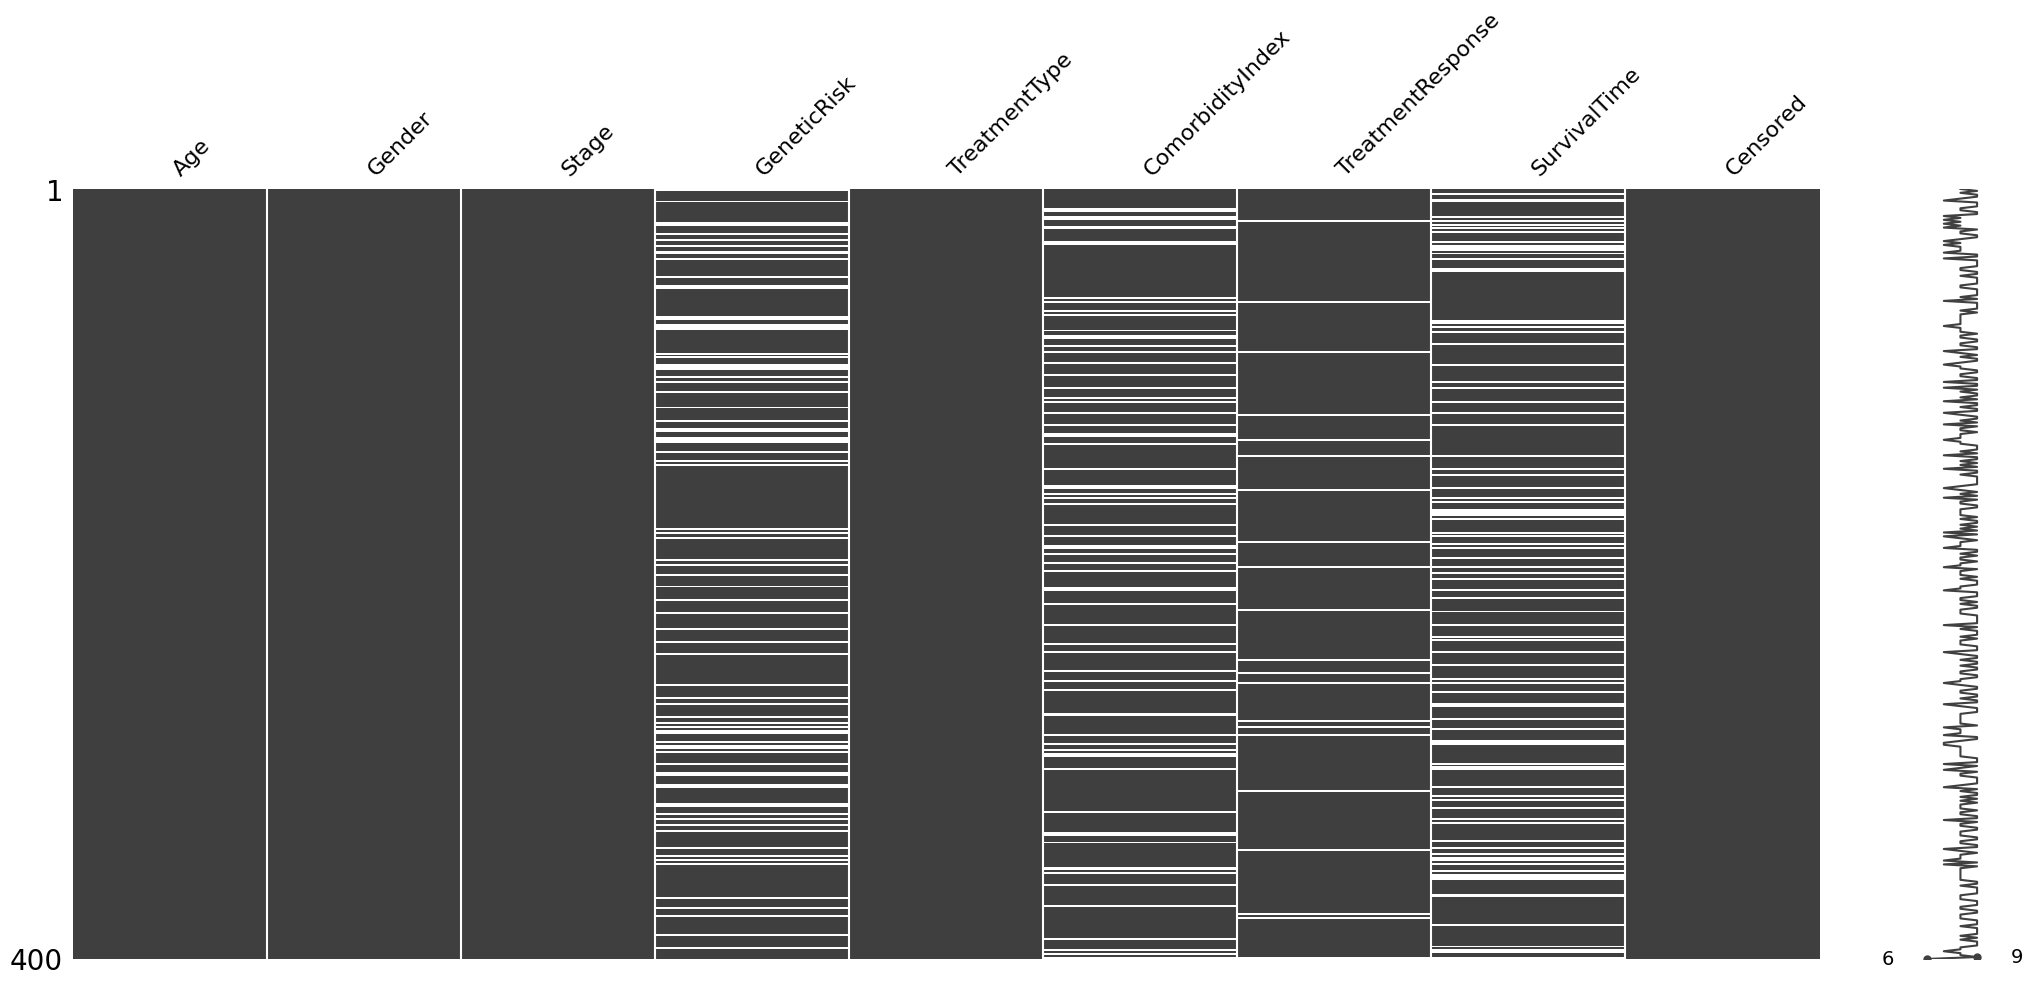

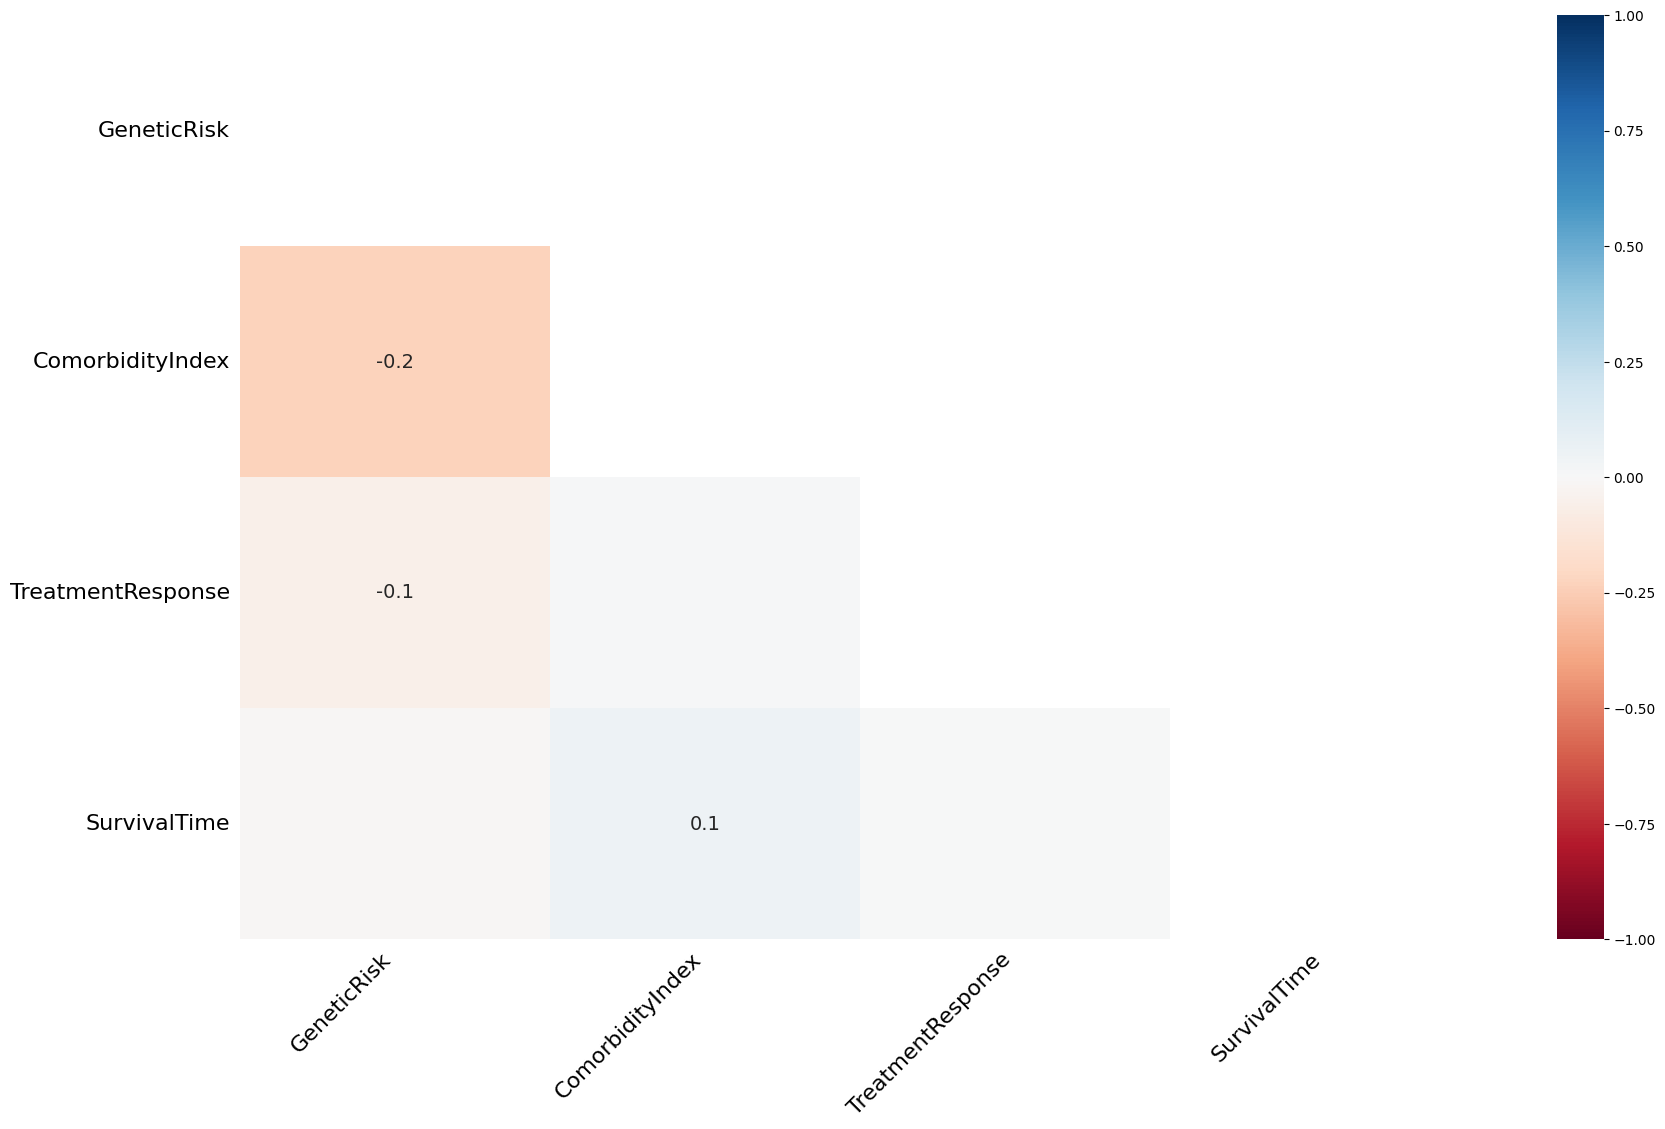

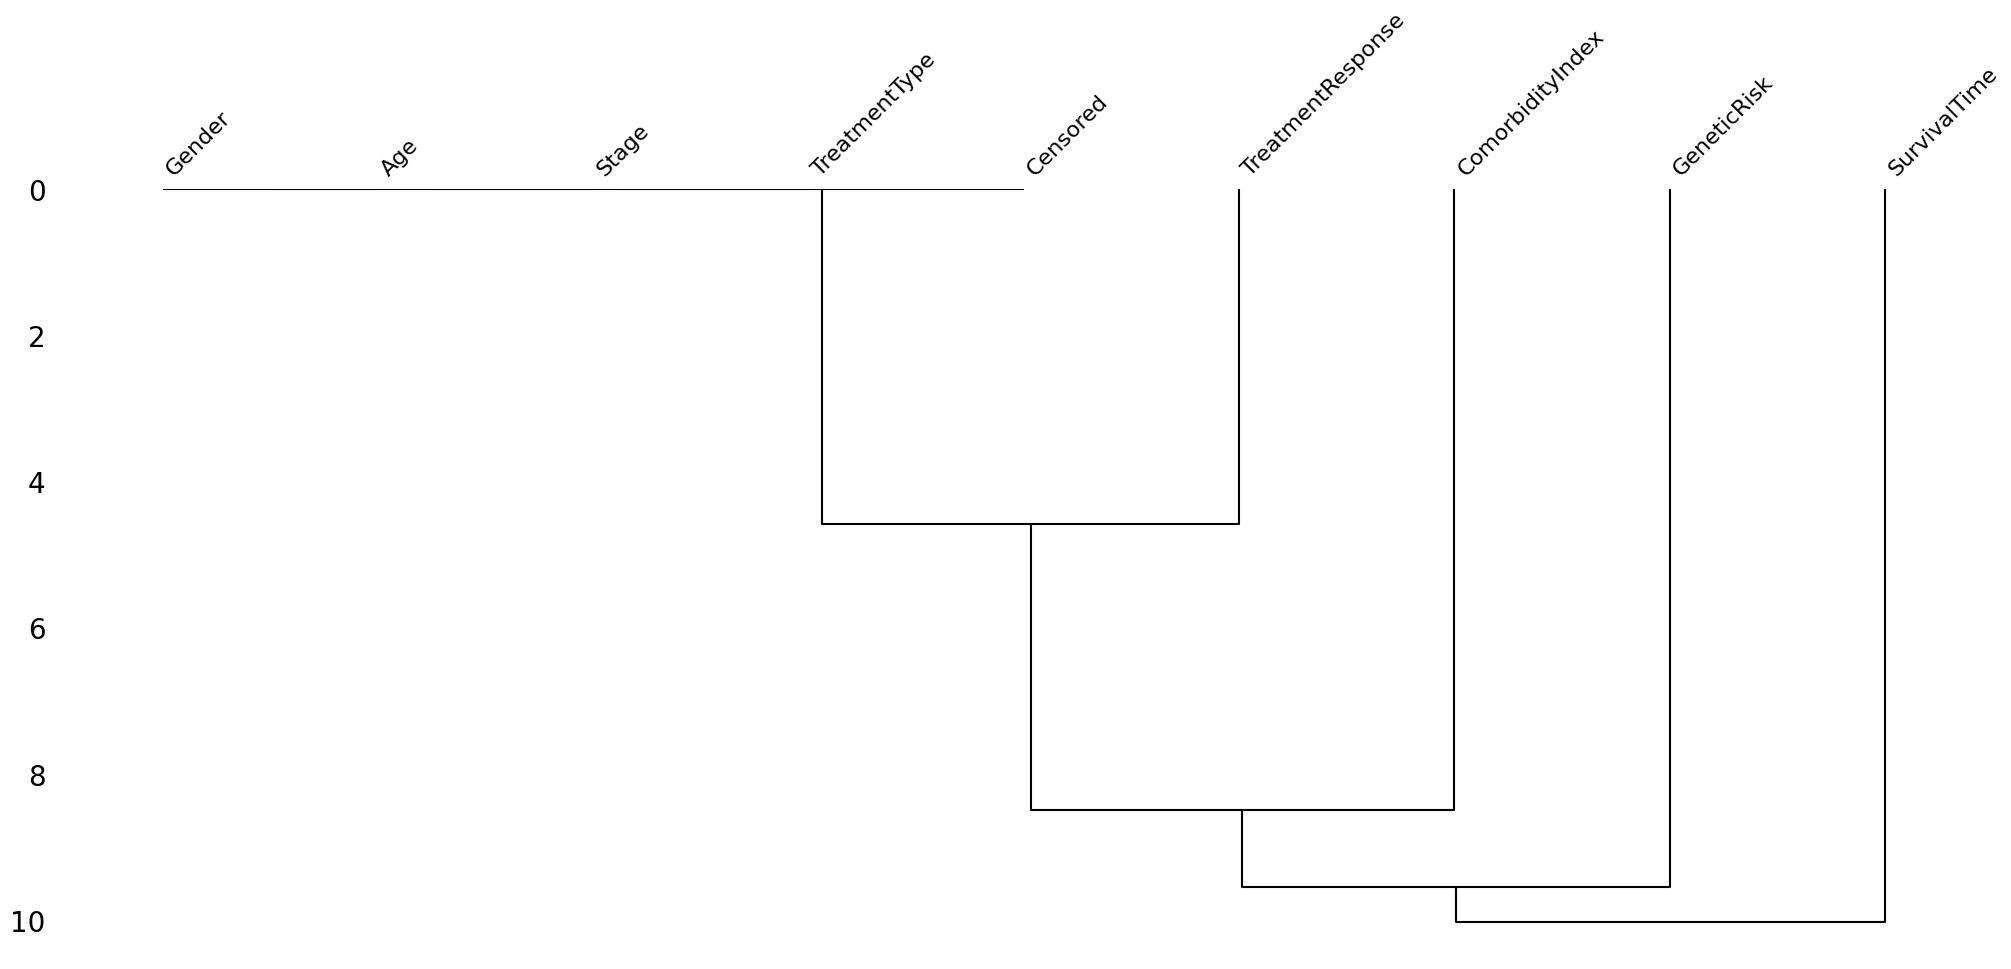

In [11]:
print("Train data:")

msno.matrix(train_df)
plt.show()

msno.heatmap(train_df)
plt.show()

msno.dendrogram(train_df)
plt.show()

Test data:


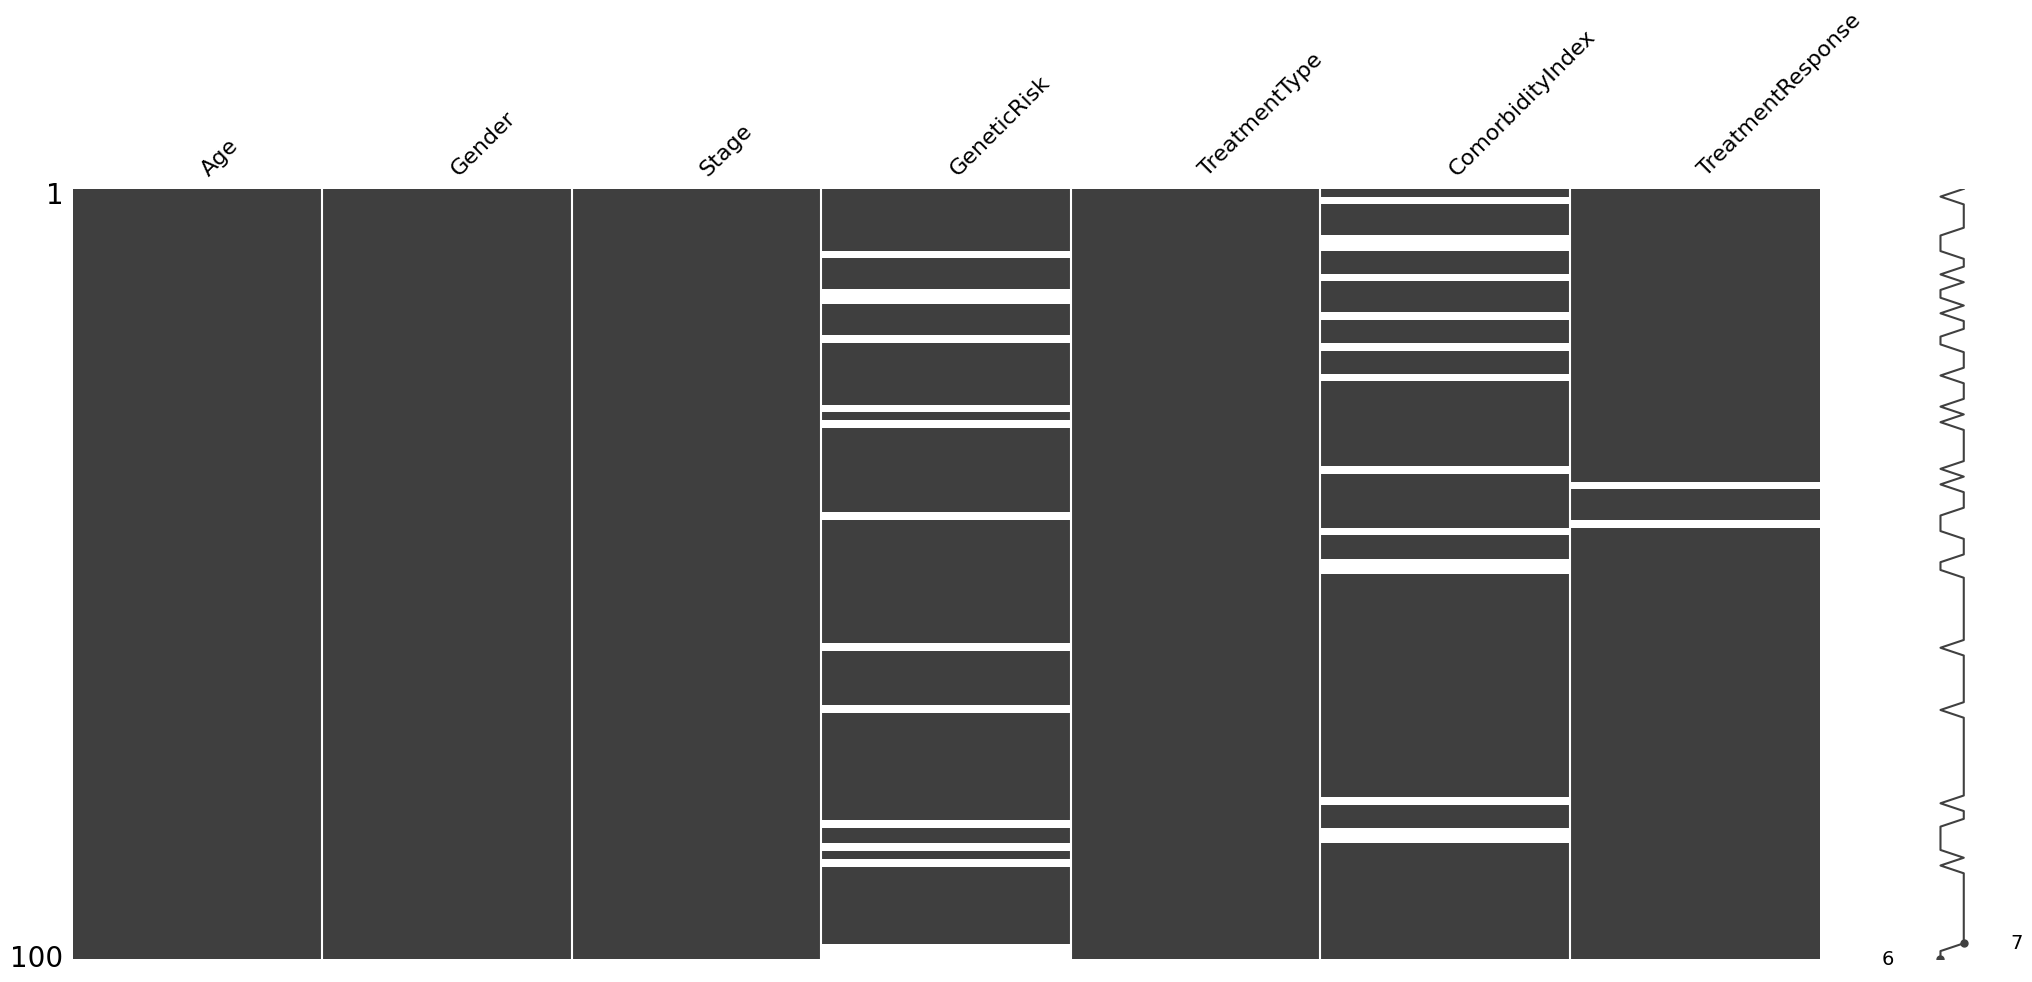

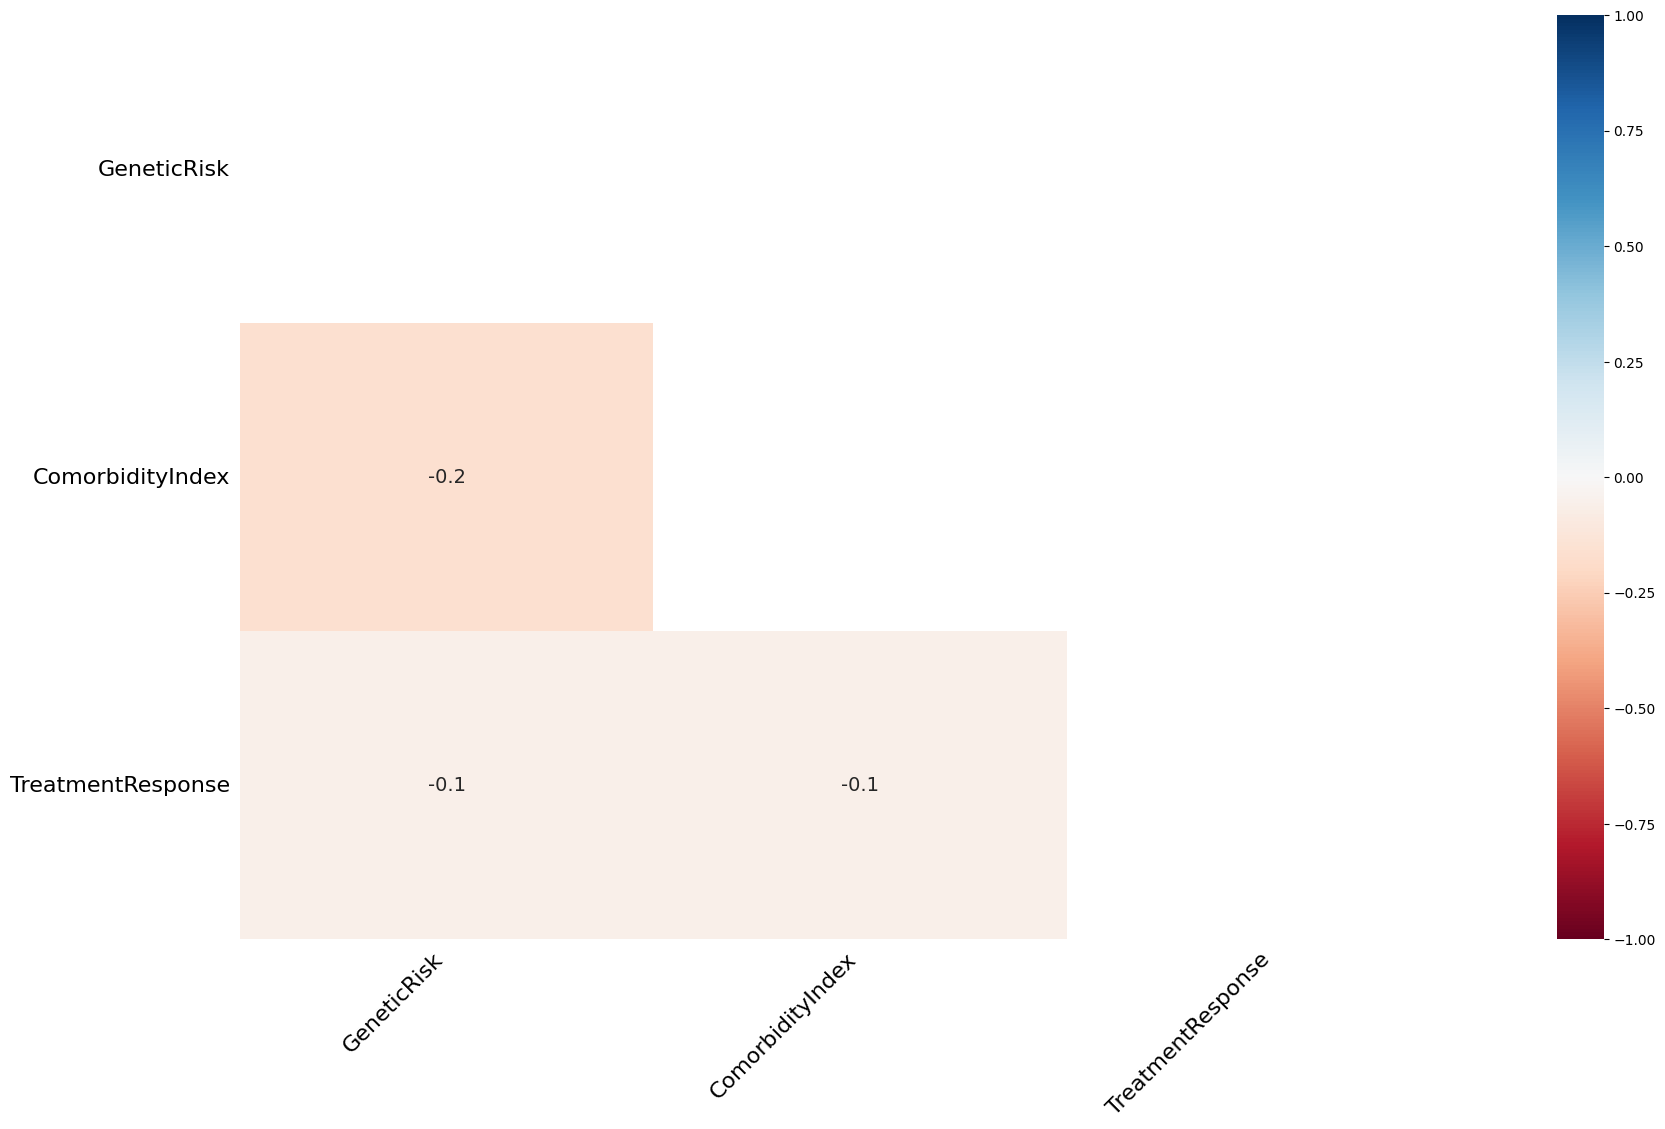

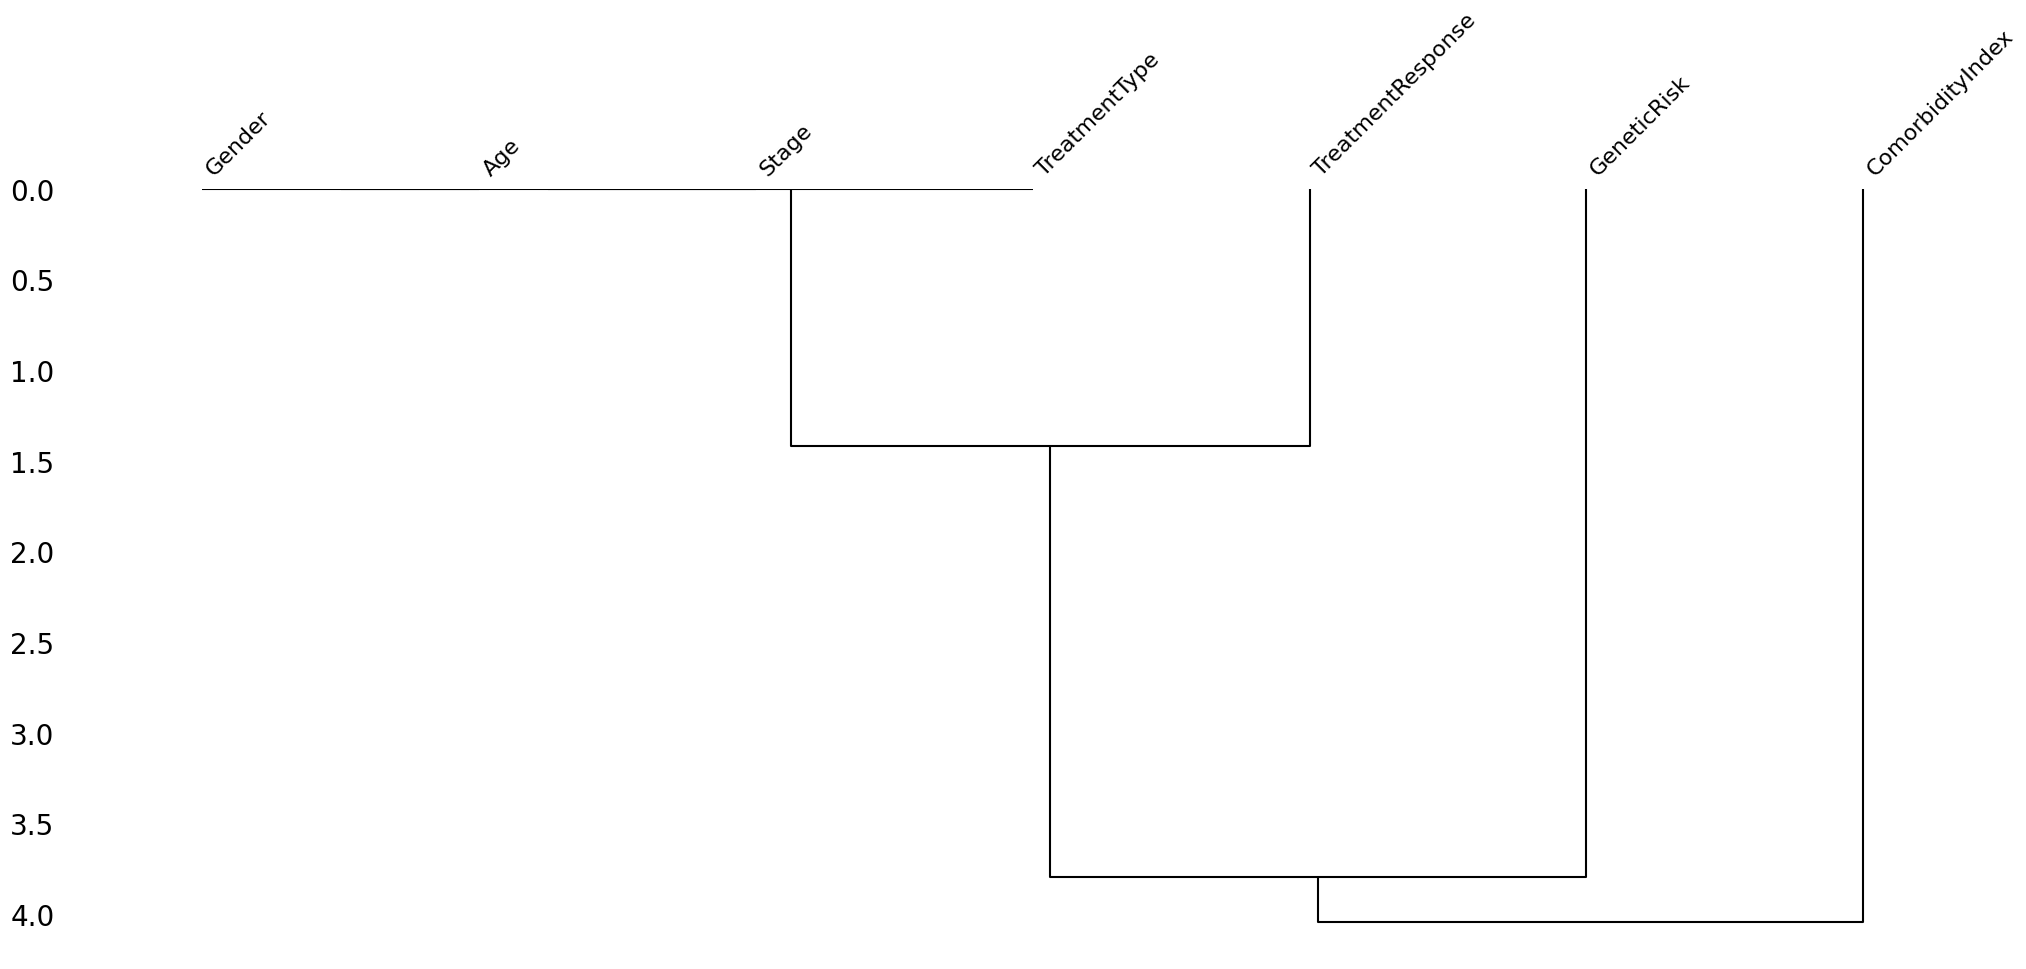

In [12]:
print("Test data:")

msno.matrix(test_df)
plt.show()

msno.heatmap(test_df)
plt.show()

msno.dendrogram(test_df)
plt.show()

## Imputation

### Create different imputers

In [166]:
# Simple, constant imputers
imputer_mean = SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="mean")
imputer_median = SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="median")
imputer_most_frequent = SimpleImputer(missing_values=np.nan, add_indicator=False, strategy="most_frequent")

In [167]:
# KNN imputer

# uniform - all points in each neighborhood are weighted equally.
# distance - weight points by the inverse of their distance. in this case, closer neighbors of a query point will have a greater influence than neighbors which are further away.

imputer_knn_uniform = KNNImputer(missing_values=np.nan, add_indicator=False, weights="uniform")
imputer_knn_distance = KNNImputer(missing_values=np.nan, add_indicator=False, weights="distance")

In [168]:
# Iterative imputers

# BayesianRidge: regularized linear regression
# RandomForestRegressor: Forests of randomized trees regression
# make_pipeline (Nystroem, Ridge): a pipeline with the expansion of a degree 2 polynomial kernel and regularized linear regression
# KNeighborsRegressor: comparable to other KNN imputation approaches

# Note that KNeighborsRegressor is different from KNN imputation, which learns from samples with missing values by using a distance metric that accounts for missing values, rather than imputing them.

imputer_iterative_bayesian = IterativeImputer(missing_values=np.nan, add_indicator=False, estimator=BayesianRidge(), max_iter=30, tol=1e-3)
imputer_iterative_random_forest = IterativeImputer(missing_values=np.nan, add_indicator=False, estimator=RandomForestRegressor(n_jobs=-1), max_iter=30, tol=2e-2)
imputer_iterative_nystroem_ridge = IterativeImputer(missing_values=np.nan, add_indicator=False, estimator=make_pipeline(Nystroem(n_jobs=-1), Ridge(alpha=1e-3)), max_iter=30, tol=2e-2)
imputer_iterative_kneighbours = IterativeImputer(missing_values=np.nan, add_indicator=False, estimator=KNeighborsRegressor(n_jobs=-1), max_iter=30, tol=1e-2)

In [169]:
data = {}
data["mean"] = {"imputer": imputer_mean}
data["median"] = {"imputer": imputer_median}
data["most_frequent"] = {"imputer": imputer_most_frequent}
data["knn_uniform"] = {"imputer": imputer_knn_uniform}
data["knn_distance"] = {"imputer": imputer_knn_distance}
data["iterative_bayesian"] = {"imputer": imputer_iterative_bayesian}
data["iterative_random_forest"] = {"imputer": imputer_iterative_random_forest}
data["iterative_nystroem_ridge"] = {"imputer": imputer_iterative_nystroem_ridge}
data["iterative_kneighbours"] = {"imputer": imputer_iterative_kneighbours}

### Fit and transform data

In [170]:
test = test_df.copy()
train_full = train_df.copy()
train_survival_time = train_df.dropna(subset=["SurvivalTime"])
train_no_survival_time = train_df[train_df["SurvivalTime"].isna()].drop(["SurvivalTime"], axis=1)

In [171]:
for imputer_method, method_dict in tqdm(data.items(), desc="Fixing data"):
    print(f"Calculating {imputer_method}...")
    method_dict["train_full"] = pd.DataFrame(method_dict["imputer"].fit_transform(train_full), columns=train_full.columns)
    method_dict["train_survival_time"] = pd.DataFrame(method_dict["imputer"].fit_transform(train_survival_time), columns=train_survival_time.columns)
    method_dict["train_no_survival_time"] = pd.DataFrame(method_dict["imputer"].fit_transform(train_no_survival_time), columns=train_no_survival_time.columns)
    method_dict["test"] = pd.DataFrame(method_dict["imputer"].fit_transform(test), columns=test.columns)

Fixing data:  44%|████▍     | 4/9 [00:00<00:00, 37.73it/s]

Calculating mean...
Calculating median...
Calculating most_frequent...
Calculating knn_uniform...
Calculating knn_distance...
Calculating iterative_bayesian...
Calculating iterative_random_forest...
Calculating iterative_nystroem_ridge...


/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1044: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1044: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/kernel_approximation.py:1044: UserWarning: n_components > n_samples. This is not possible.
n_components was set to n_samples, which results in inefficient evaluation of the full kernel.
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/kernel_approximation.py

Calculating iterative_kneighbours...


Fixing data: 100%|██████████| 9/9 [00:18<00:00,  2.06s/it]


### Evaluate imputers

In [172]:
# Censored Mean Squared Error (cMSE)

def cMSE(y_hat, y, c):
    err = y - y_hat
    err = (1 - c) * err**2 + c * np.maximum(0, err)**2
    return np.sum(err) / err.shape[0]

## Model Development and Evaluation

In [173]:
models = {
    "Linear Regression": LinearRegression(n_jobs=-1),
    "Ridge": Ridge(alpha=1e-3),
    "SVM": SVR(C=2),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_jobs=-1),
    "XGBoost": XGBRegressor(max_depth=50)
}

In [174]:
test_size = 0.3
best_score = {
    "model": None,
    "imput_method": None,
    "score": np.inf
}

for imput_method, method_dict in data.items():
    print(f"Using '{imput_method}' imputer on data without survival time imputed:")
    
    temp_df = method_dict["train_survival_time"].copy()
    X = temp_df.drop(columns=["SurvivalTime", "Censored"], axis=1)
    y = temp_df[["SurvivalTime", "Censored"]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    pca = PCA(n_components=0.95)  # Retain 95% of the variance
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)
    
    for model_name, model in models.items():
        print(f"\tTraining on part of the dataset with SurvivalTime:")
        model.fit(X_train_scaled, y_train["SurvivalTime"])
        predictions = model.predict(X_test_scaled)

        score = round(cMSE(predictions, y_test["SurvivalTime"], y_test["Censored"]), 3) # watch out for right argument order...
        print(f"\t\t{model_name} - cMSE: {score}")
        
        # Predict missing SurvivalTime data
        print(f"\tTraining on full dataset with SurvivalTime predicted:")
        temp_df = method_dict["train_no_survival_time"].copy()
        X_new = temp_df.drop(columns=["Censored"], axis=1)
        c_new = temp_df["Censored"]
        
        X_new_scaled = scaler.transform(X_new)
        y_new = model.predict(X_new_scaled)
        
        X_new = pd.DataFrame(X_new, columns=X.columns)
        X_new["SurvivalTime"] = y_new
        new_df = pd.concat([X_new, c_new], axis=1)
        old_df = pd.concat([X, y], axis=1)
        
        full_df = pd.concat([old_df, new_df], ignore_index=True)
        X = full_df.drop(columns=["SurvivalTime", "Censored"], axis=1)
        y = full_df[["SurvivalTime", "Censored"]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        pca = PCA(n_components=0.95)  # Retain 95% of the variance
        X_train_scaled = pca.fit_transform(X_train_scaled)
        X_test_scaled = pca.transform(X_test_scaled)
        
        model.fit(X_train_scaled, y_train["SurvivalTime"])
        predictions = model.predict(X_test_scaled)

        score = round(cMSE(predictions, y_test["SurvivalTime"], y_test["Censored"]), 3) # watch out for right argument order...
        print(f"\t\t{model_name} - cMSE: {score}")
        
        if score < best_score["score"]:
            best_score["score"] = score
            best_score["imput_method"] = imput_method
            best_score["model"] = model_name
        

Using 'mean' imputer on data without survival time imputed:
	Training on part of the dataset with SurvivalTime:
		Linear Regression - cMSE: 1.929
	Training on full dataset with SurvivalTime predicted:
		Linear Regression - cMSE: 1.188
	Training on part of the dataset with SurvivalTime:
		Ridge - cMSE: 1.188
	Training on full dataset with SurvivalTime predicted:
		Ridge - cMSE: 0.864
	Training on part of the dataset with SurvivalTime:
		SVM - cMSE: 0.984
	Training on full dataset with SurvivalTime predicted:
		SVM - cMSE: 1.109
	Training on part of the dataset with SurvivalTime:
		Decision Tree - cMSE: 1.394
	Training on full dataset with SurvivalTime predicted:
		Decision Tree - cMSE: 1.765
	Training on part of the dataset with SurvivalTime:
		Random Forest - cMSE: 1.074
	Training on full dataset with SurvivalTime predicted:
		Random Forest - cMSE: 1.109
	Training on part of the dataset with SurvivalTime:
		XGBoost - cMSE: 1.312
	Training on full dataset with SurvivalTime predicted:
		

In [175]:
print(best_score)

{'model': 'Ridge', 'imput_method': 'mean', 'score': 0.864}


## Handling Missing Data Without Imputation

In [83]:
list(train_df.columns)

['Age',
 'Gender',
 'Stage',
 'GeneticRisk',
 'TreatmentType',
 'ComorbidityIndex',
 'TreatmentResponse',
 'SurvivalTime',
 'Censored']

In [286]:
test_size = 0.1
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

models_no_imput = {
    "BaggingRegressor": BaggingRegressor(n_estimators=50, n_jobs=-1),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "HistGradientBoostingRegressor": HistGradientBoostingRegressor(max_iter=2000, max_leaf_nodes=None,
                                                                   learning_rate=0.005, l2_regularization=0.005,
                                                                #    monotonic_cst=[0, 0, 0, 0, 0, 0, 0],
                                                                   validation_fraction=0.3, warm_start=True)
}

train_survival_time = train_df.dropna(subset=["SurvivalTime"])
train_no_survival_time = train_df[train_df["SurvivalTime"].isna()].drop(["SurvivalTime"], axis=1)

X = train_survival_time.drop(columns=["SurvivalTime", "Censored"], axis=1)
y = train_survival_time[["SurvivalTime", "Censored"]]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


for model_name, model in models_no_imput.items():
    score_1 = 0.0
    score_2 = 0.0
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.values[train_index], X.values[test_index]
        y_train, y_test = y.values[train_index], y.values[test_index]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train[:, 0])
        predictions = model.predict(X_test_scaled)

        score_1 += round(cMSE(predictions, y_test[:, 0], y_test[:, 1]), 3) # watch out for right argument order...
        
        # Predict missing SurvivalTime data
        X_new = train_no_survival_time.drop(columns=["Censored"], axis=1)
        c_new = train_no_survival_time["Censored"]
        
        X_new_scaled = scaler.transform(X_new)
        y_new = model.predict(X_new_scaled)
        
        X_new = pd.DataFrame(X_new, columns=X.columns)
        X_new["SurvivalTime"] = y_new
        new_df = pd.concat([X_new, c_new], axis=1)
        old_df = pd.concat([X, y], axis=1)
        
        full_df = pd.concat([old_df, new_df], ignore_index=True)
        X = full_df.drop(columns=["SurvivalTime", "Censored"], axis=1)
        y = full_df[["SurvivalTime", "Censored"]]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
        
        model.fit(X_train_scaled, y_train["SurvivalTime"])
        predictions = model.predict(X_test_scaled)

        score_2 += round(cMSE(predictions, y_test["SurvivalTime"], y_test["Censored"]), 3) # watch out for right argument order...
        
    score_1 /= n_splits
    score_2 /= n_splits 
        
    print(f"Training on part of the dataset with SurvivalTime:")
    print(f"\t{model_name} - cMSE: {score_1}")
    print(f"Training on full dataset with SurvivalTime predicted:")
    print(f"\t{model_name} - cMSE: {score_2}")


/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted

Training on part of the dataset with SurvivalTime:
	BaggingRegressor - cMSE: 1.5239999999999998
Training on full dataset with SurvivalTime predicted:
	BaggingRegressor - cMSE: 1.1488
Training on part of the dataset with SurvivalTime:
	DecisionTreeRegressor - cMSE: 0.7243999999999999
Training on full dataset with SurvivalTime predicted:
	DecisionTreeRegressor - cMSE: 0.437


/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


Training on part of the dataset with SurvivalTime:
	HistGradientBoostingRegressor - cMSE: 0.2404
Training on full dataset with SurvivalTime predicted:
	HistGradientBoostingRegressor - cMSE: 0.1102


/home/pcend/Piotr/kod/myeloma-survival-prediction/venv/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


## Feature Analysis and Model Interpretation

## Test prediction and submission file creation

In [193]:
# With imputer

print(f"Using {best_score}")

test_size = 0.1
model = models[best_score["model"]]

# TRAIN

temp_df = data[best_score["imput_method"]]["train_survival_time"].copy()
X = temp_df.drop(columns=["SurvivalTime", "Censored"], axis=1)
y = temp_df[["SurvivalTime", "Censored"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

print(f"Training on part of the dataset with SurvivalTime:")
model.fit(X_train_scaled, y_train["SurvivalTime"])
predictions = model.predict(X_test_scaled)

score = round(cMSE(predictions, y_test["SurvivalTime"], y_test["Censored"]), 3) # watch out for right argument order...
print(f"{best_score['model']} - cMSE: {score}")

# Predict missing SurvivalTime data
print(f"Training on full dataset with SurvivalTime predicted:")
temp_df = data[best_score["imput_method"]]["train_no_survival_time"].copy()
X_new = temp_df.drop(columns=["Censored"], axis=1)
c_new = temp_df["Censored"]

X_new_scaled = scaler.transform(X_new)
y_new = model.predict(X_new_scaled)

X_new = pd.DataFrame(X_new, columns=X.columns)
X_new["SurvivalTime"] = y_new
new_df = pd.concat([X_new, c_new], axis=1)
old_df = pd.concat([X, y], axis=1)

full_df = pd.concat([old_df, new_df], ignore_index=True)
X = full_df.drop(columns=["SurvivalTime", "Censored"], axis=1)
y = full_df[["SurvivalTime", "Censored"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_scaled = pca.fit_transform(X_train_scaled)
X_test_scaled = pca.transform(X_test_scaled)

model.fit(X_train_scaled, y_train["SurvivalTime"])
predictions = model.predict(X_test_scaled)

score = round(cMSE(predictions, y_test["SurvivalTime"], y_test["Censored"]), 3) # watch out for right argument order...
print(f"{best_score['model']} - cMSE: {score}")

# TEST PREDICTION

X = data[best_score["imput_method"]]["test"].copy()
X_scaled = scaler.transform(X)
X_scaled = pca.transform(X_scaled)
test_predictions = model.predict(X_scaled)

Using {'model': 'Ridge', 'imput_method': 'iterative_random_forest', 'score': 0.839}
Training on part of the dataset with SurvivalTime:
Ridge - cMSE: 1.917
Training on full dataset with SurvivalTime predicted:
Ridge - cMSE: 1.166


In [268]:
# Without imputer

test_size = 0.1
model_name = "HistGradientBoostingRegressor"
model = HistGradientBoostingRegressor(max_iter=3000, max_leaf_nodes=None, learning_rate=0.005, l2_regularization=0.002, 
                                      # monotonic_cst=[0, 0, -1, 0, 0, 0, 0], 
                                      validation_fraction=0.2, warm_start=True)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True)

test_X_input = test_df.copy()
train_survival_time = train_df.dropna(subset=["SurvivalTime"])
train_no_survival_time = train_df[train_df["SurvivalTime"].isna()].drop(["SurvivalTime"], axis=1)

X = train_survival_time.drop(columns=["SurvivalTime", "Censored"], axis=1)
y = train_survival_time[["SurvivalTime", "Censored"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train["SurvivalTime"])
predictions = model.predict(X_test_scaled)

score = round(cMSE(predictions, y_test["SurvivalTime"], y_test["Censored"]), 3) # watch out for right argument order...
print(f"\t{model_name} - cMSE: {score}")

score_1 /= n_splits    
print(f"Training on part of the dataset with SurvivalTime:")
print(f"\t{model_name} - cMSE: {score_1}")

# Predict missing SurvivalTime data
X_new = train_no_survival_time.drop(columns=["Censored"], axis=1)
c_new = train_no_survival_time["Censored"]

X_new_scaled = scaler.transform(X_new)
y_new = model.predict(X_new_scaled)

X_new = pd.DataFrame(X_new, columns=X.columns)
X_new["SurvivalTime"] = y_new
new_df = pd.concat([X_new, c_new], axis=1)
old_df = pd.concat([X, y], axis=1)

full_df = pd.concat([old_df, new_df], ignore_index=True)
X = full_df.drop(columns=["SurvivalTime", "Censored"], axis=1)
y = full_df[["SurvivalTime", "Censored"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model.fit(X_train_scaled, y_train["SurvivalTime"])
predictions = model.predict(X_test_scaled)

score = round(cMSE(predictions, y_test["SurvivalTime"], y_test["Censored"]), 3) # watch out for right argument order...
print(f"\t{model_name} - cMSE: {score}")


score_2 /= n_splits 
print(f"Training on full dataset with SurvivalTime predicted:")
print(f"\t{model_name} - cMSE: {score_2}")

# Test predictions
test_X_scaled = scaler.transform(test_X_input)
test_predictions = model.predict(test_X_scaled)

Training on part of the dataset with SurvivalTime:
	HistGradientBoostingRegressor - cMSE: 1.007
Training on full dataset with SurvivalTime predicted:
	HistGradientBoostingRegressor - cMSE: 1.249


In [245]:
test_predictions

array([4.82135667, 4.47187019, 3.2039176 , 4.5045465 , 3.92093045,
       4.95822833, 4.58100504, 4.19401831, 4.050305  , 2.26263446,
       4.03743233, 3.7461066 , 4.36636951, 5.27063536, 4.41589472,
       3.66551202, 3.45616813, 3.31123152, 3.74491891, 2.61617892,
       4.31151729, 4.08928879, 4.47682049, 2.56535398, 4.36788972,
       4.31577521, 5.1612787 , 3.99280978, 4.16238422, 2.57947804,
       4.2823336 , 3.35781599, 3.73215641, 3.96455315, 3.27339487,
       4.30512315, 3.66953971, 4.32456056, 4.44926377, 3.48223275,
       4.89390254, 3.21750788, 3.25434496, 4.37854389, 4.36433906,
       4.51782884, 3.1624673 , 4.06239698, 3.95960773, 4.00161486,
       3.17587496, 5.37820687, 4.05531449, 2.79167875, 3.02309157,
       5.04263265, 4.19801149, 3.72664594, 4.90039907, 4.48578182,
       3.82156283, 3.84127017, 4.74702358, 2.88465248, 4.70390975,
       3.16925868, 4.07608579, 3.67027369, 4.09508458, 3.40729452,
       3.34734802, 4.44876775, 3.81252641, 2.21417784, 4.28067

In [246]:
# Generate submission file - id, TARGET

submission = pd.DataFrame({'TARGET': test_predictions}).reset_index().rename(columns={'index': 'id'})

submission.head()

submission.to_csv("data/submission.csv", index=False)
submission.columns

Index(['id', 'TARGET'], dtype='object')